In [1]:
from pylab import *
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

In [2]:
def load_engine_data(file_path):
    """
    Load gasoline engine data from a CSV file and filter out RPM <1000rpm and >4000rpm.

    Parameters:
    file_name (str): Path to the CSV file.

    Returns:
    tuple: Filtered arrays for RPM, torque, fuel_rate, consumption, efficiency and displacement.
    """
    # Open and read CSV file
    with open(file_path, 'r') as file:
        data = pd.read_csv(file, sep=';')

    # Extract columns and assign meaningful variable names
    rpm_values = data.iloc[:, 0].values
    torque_values = data.iloc[:, 1].values
    fuel_rate_values = data.iloc[:, 2].values
    consumption_values = data.iloc[:, 3].values
    efficiency_values = data.iloc[:, 4].values
    displacement_value = data.iloc[0, 5]

    # Apply filtering criteria for valid RPM range (1000 < RPM < 4000)
    valid_indices = np.where((rpm_values > 1000) & (rpm_values < 4000))[0]

    # Filter data based on valid indices
    rpm_filtered = rpm_values[valid_indices]
    torque_filtered = torque_values[valid_indices]
    fuel_rate_filtered = fuel_rate_values[valid_indices]
    consumption_filtered = consumption_values[valid_indices]
    efficiency_filtered = efficiency_values[valid_indices]

    return rpm_filtered, torque_filtered, fuel_rate_filtered, consumption_filtered, efficiency_filtered, displacement_value


In [3]:
def calculate_T_WOT(rpm_values, torque_values):
    """
    Calculate the CWOT (maximum torque for each unique RPM value).
    
    Parameters:
    rpm_values (array): Array of RPM values in ascending order.
    torque_values (array): Array of corresponding torque values.

    Returns:
    array: Array where each unique RPM has its maximum torque repeated across its occurrences.
    """
    # Find where RPM changes (indicating a new unique RPM)
    rpm_change_indices = np.where(np.diff(rpm_values) > 0)[0]

    # Add the last index to include the final RPM change
    rpm_change_indices = np.concatenate((rpm_change_indices, [len(rpm_values) - 1]))

    # Calculate the length of each RPM segment (number of repeated occurrences)
    segment_lengths = np.diff(np.concatenate(([0], rpm_change_indices + 1)))

    # Repeat the maximum torque values for each unique RPM segment
    torque_wot = np.repeat(torque_values[rpm_change_indices], segment_lengths)

    return torque_wot


In [4]:
def calculate_wot_boundary(rpm_value, rpm_values, torque_wot_values):
    """
    Interpolate the WOT boundary for a given RPM value.

    Parameters:
    rpm_value (float): The RPM value for which the WOT boundary is calculated.
    rpm_values (array): Array of RPM values in ascending order.
    torque_wot_values (array): Array of corresponding WOT torque values.

    Returns:
    float: Interpolated WOT boundary torque value for the given RPM.
    """
    # Find the position where the RPM value fits in the sorted array
    index = np.searchsorted(rpm_values, rpm_value)

    if index == 0:
        # If the RPM value is lower than the first RPM, return the first torque value
        return torque_wot_values[0]
    else:
        # Perform linear interpolation between the two closest RPM values
        rpm_lower = rpm_values[index - 1]
        rpm_upper = rpm_values[index]
        torque_lower = torque_wot_values[index - 1]
        torque_upper = torque_wot_values[index]

        interpolated_value = torque_lower + (torque_upper - torque_lower) * (rpm_value - rpm_lower) / (rpm_upper - rpm_lower)
        return interpolated_value


In [5]:
def plot_maps(parameters, torque_wot, rpm_values):
    """
    Plot a contour map based on engine parameters, WOT torque values, and RPM values.

    Parameters:
    parameters (tuple): Engine parameters (n_i, fmep0, p0, Q0, D).
    torque_wot (array): Array of WOT torque values.
    rpm_values (array): Array of RPM values in ascending order.
    """
    # Generate an RPM range and corresponding angular velocity
    rpm_range = np.arange(rpm_values[0], np.max(rpm_values), 20)
    angular_velocity = rpm_range * 2 * np.pi / 60

    # Generate torque values for the grid
    torque_range = np.linspace(0, np.abs(np.max(torque_wot)) + 10, len(rpm_range))

    # Create the meshgrid for RPM and torque
    RPM_grid, torque_grid = np.meshgrid(rpm_range, torque_range)
    angular_velocity_grid = RPM_grid * 2 * np.pi / 60

    # Calculate WOT boundary values for each RPM and reshape to match the grid
    wot_boundary_values = np.array([calculate_wot_boundary(rpm, rpm_values, torque_wot) for rpm in rpm_range])
    wot_boundary_grid = np.tile(wot_boundary_values, (len(torque_range), 1))

    # Extract parameters
    n_i, fmep0, p0, Q0, D = parameters

    # Calculate mean effective pressure (MEP)
    mep_values = (torque_grid * angular_velocity_grid) / (
        (torque_grid * angular_velocity_grid) / n_i +
        (fmep0 * angular_velocity_grid * D) / (4 * np.pi * n_i) +
        (p0 * angular_velocity_grid ** 3 * D) / (4 * np.pi * n_i) +
        (Q0 * D) / n_i
    )

    # Calculate fuel consumption (Z) and apply the WOT boundary condition
    fuel_consumption = 3600 / (mep_values * 43.5)
    fuel_consumption[torque_grid > wot_boundary_grid] = 0  # Set fuel consumption to 0 where torque exceeds WOT boundary

    # Define contour levels
    contour_levels = np.array([200, 220, 230, 240, 260, 280, 300, 350, 400, 500, 800, 1500])
    contour_labels = contour_levels[1:]

    # Plot contour map
    contour_lines = plt.contour(RPM_grid, torque_grid, fuel_consumption, levels=contour_levels, colors='k')
    plt.clabel(contour_lines, levels=contour_labels, inline=True, fontsize=12)

    # Plot filled contours
    plt.contourf(RPM_grid, torque_grid, fuel_consumption, levels=contour_levels, cmap='Spectral')
    plt.colorbar(label='Fuel Consumption Rate (g/kWh)')

    # Add labels and title
    plt.xlabel('Engine RPM')
    plt.ylabel('Torque (Nm)')
    plt.title('Engine Performance Contour Map')

    # Show the plot
    plt.show()


In [15]:
def optimize_engine_parameters(file_name, print_maps=False):
    """
    Optimize engine parameters based on input data and optionally plot maps.

    Parameters:
    file_name (str): Path to the input file containing engine data.
    print_maps (bool): Whether to generate and display performance maps.

    Returns:
    list: Optimized parameters and key results.
    """
    # Load and prepare data
    rpm, torque, fuel_rate, consumption, efficiency, displacement = load_engine_data(file_name)
    torque_wot = calculate_T_WOT(rpm, torque)
    
    # Determine the torque limit for optimal efficiency
    torque_limit = torque[efficiency == np.max(efficiency)][0]

    # Apply filtering to limit torque under a percentage of WOT
    prop = 0.5
    valid_indices = np.where(torque < torque_wot * prop)
    torque, rpm, fuel_rate, consumption = torque[valid_indices], rpm[valid_indices], fuel_rate[valid_indices], consumption[valid_indices]
    torque_wot = torque_wot[valid_indices]

    # Calculate angular velocity
    angular_velocity = rpm * 2 * np.pi / 60

    # Define the objective function for optimization
    def objective_function(parameters):
        n_i, fmep0, p0, Q0 = parameters
        mep = (torque * angular_velocity) / (
            (torque * angular_velocity) / n_i +
            (100 * fmep0 * angular_velocity * displacement) / (4 * np.pi * n_i) +
            (p0 / 1000) * (angular_velocity ** 3) * displacement / (4 * np.pi * n_i) +
            (Q0 * displacement * 1000) / n_i
        )
        error = np.abs((consumption - (3600 / (mep * 43.5))) / consumption * 100)
        return np.sum(error)

    # Initial parameters and bounds
    initial_params = [np.max(efficiency) / 100, 1.2, 1, 1]
    parameter_bounds = [(np.max(efficiency) / 100, 1), (0, 3), (0, 2), (0, 2)]

    # Perform optimization
    optimization_result = minimize(objective_function, initial_params, method='Powell', bounds=parameter_bounds)
    optimal_params = optimization_result.x
    optimal_params_scaled = optimal_params * [1, 100, 0.001, 1000]

    # Calculate mid-point error
    mean_error = objective_function(optimal_params) / len(rpm)

    # Optionally generate and display performance maps
    if print_maps:
        n_i, fmep0, p0, Q0 = optimal_params_scaled
        mep = (torque * angular_velocity) / (
            (torque * angular_velocity) / n_i +
            (fmep0 * angular_velocity * displacement) / (4 * np.pi * n_i) +
            (p0 * (angular_velocity ** 3) * displacement) / (4 * np.pi * n_i) +
            (Q0 * displacement) / n_i
        )
        relative_error = (3600 / (mep * 43.5) - consumption) / consumption * 100
        max_error = np.max(np.abs(relative_error))

        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list(
            'custom_cmap', [(0, 'darkred'), (0.25, 'orange'), (0.5, 'white'), (0.75, 'dodgerblue'), (1, 'darkblue')]
        )

        # Calculate figure size for required resolution
        width_px=1500
        dpi=200
        
        width_in = width_px / dpi
        height_in = width_in * (502 / 763)  # Maintain aspect ratio

        # Plot the scatter plot with color representing the relative error
        fig, ax = plt.subplots(figsize=(width_in, height_in), dpi=dpi)
        plt.scatter(rpm, torque, c=relative_error, cmap=cmap, s=100, vmin=-max_error, vmax=max_error, edgecolors='black')
        color_bar = plt.colorbar()
        color_bar.ax.tick_params(labelsize=12)
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
        color_bar.set_label('Relative Error [%]', fontsize=12)
        plt.xlabel('Engine Speed N [rpm]', fontsize=12)
        plt.ylabel('Torque T [Nm]', fontsize=12)
        plt.title('Relative Error Map')
        plt.show()

        # Append displacement and plot performance maps
        optimal_params_scaled = list(optimal_params_scaled) + [displacement]
        plot_maps(optimal_params_scaled, torque_wot, rpm)

    # Return key results
    results = [np.max(efficiency), displacement] + list(optimal_params_scaled) + [mean_error]
    return results


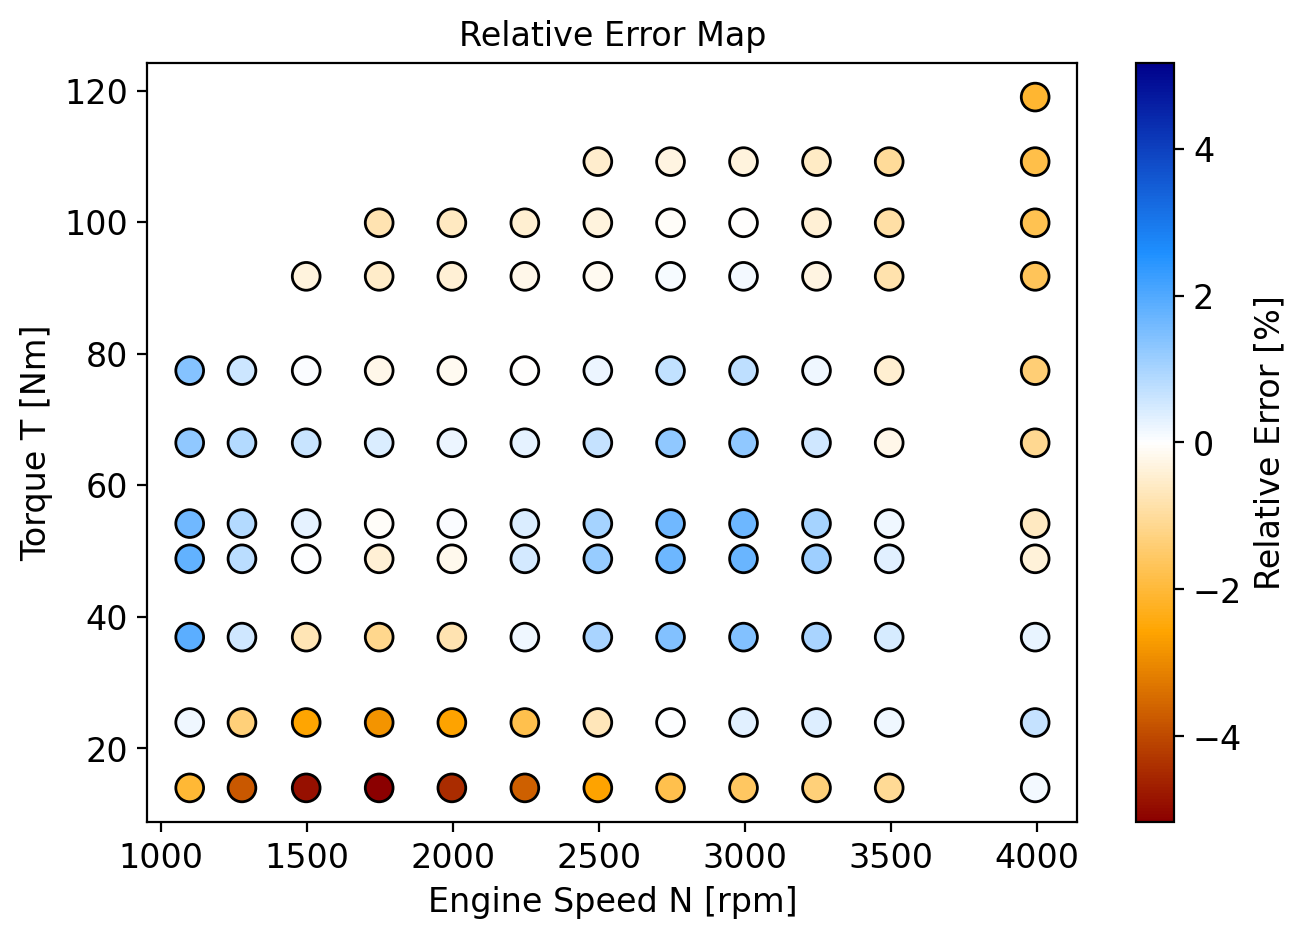

/var/folders/1k/jbjx2xln75q9cx16ff6btsz00000gn/T/ipykernel_3472/600235978.py:37: RuntimeWarning: divide by zero encountered in divide
  fuel_consumption = 3600 / (mep_values * 43.5)


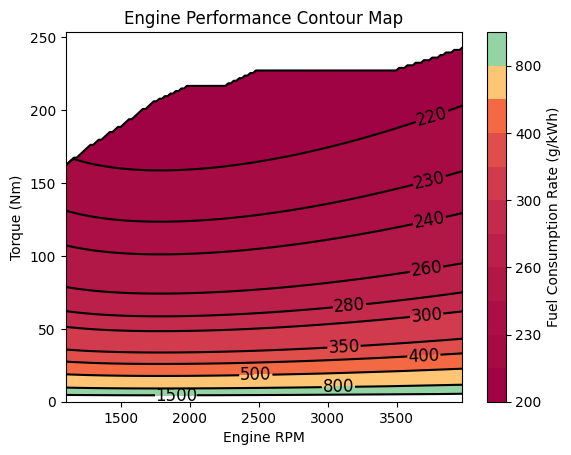

[37.6,
 2.488,
 0.44759551094755556,
 107.50393740098644,
 0.00042658229406635433,
 443.07205547348013,
 2.488,
 0.986838063295482]

In [16]:
optimize_engine_parameters('M2.5T2_GV.csv',True)

In [8]:
# Read the list of engine files
df = pd.read_csv('list_engine.csv', sep=';')
engine_names = df.iloc[:, 0].values

# Initialize results list
results = []

# Loop through each engine and optimize parameters
for engine_name in engine_names:
    file_name = engine_name + ".csv"
    results.append(optimize_engine_parameters(file_name,False))

# Define column names for the results DataFrame
columns = ['max_eff', 'D', 'n_i', 'fmep0', 'p0', 'Q0', 'ecart']

# Create a DataFrame from the results
summary = pd.DataFrame(results, index=engine_names, columns=columns)

# Save the results to a CSV file
results_file_name = 'results_thermal.csv'
summary.to_csv(results_file_name)

print('End')

End
